# ECE 157A/272A Homework 3

You are a new ML engineer on your first day at the semiconductor company **WIWI**.  
Your mentor, **Kiwi**, approaches you and says:  
> “The testing team just sent us wafer map test data from the new product line.”

Kiwi’s team usually starts by labeling the wafer maps according to their **failure patterns** whenever new test data arrives.  
That’s because wafer maps are directly related to **yield**, and by analyzing the patterns, engineers can infer which **process step** or **test stage** may have caused issues — leading to potential solutions.

Kiwi continues,  
> “I’d like you to build a Machine Learning model that can quickly classify the wafer map failure patterns we used to label manually.”

Then adds,  
> “You’re the only ML expert on our team. So you’ll not only need to build the model and report the results, but also **explain** to us — including me — *how* the model makes its classifications, *how accurate* it is, and *what principles* it’s based on.  
> I’ll give you **two weeks**. We have high expectations!”

You’d love to use a **Deep Neural Network**, but you decide it’s better to start simple to make your explanations and reasoning clear to the team.  
Over the next two weeks, you make the following plan:

1. Instead of using the new wafer map data right away, start with a well-known, validated dataset — **WM-811K**.  
2. Explore the data: *What types of failure patterns are we trying to identify?*  
3. Determine what **features** are needed to classify those patterns.  
4. Choose an appropriate **model** for classification.  
5. Based on the results, figure out how to **explain and justify** your model’s reasoning in a way that’s easy for everyone to understand.


### STEP 0. Setup LLM

(Stepping out of the story for a moment,) this assignment is **similar yet different** from the previous ones.  
In earlier assignments, your goal was to craft a **single precise prompt**.  
This time, however, your goal is to **leverage an LLM to complete a long piece of code**.  
Still, one thing remains the same — you must understand **what your code does** after generating it.

What the TAs want to see this time is **how you communicate with the LLM**.  
Therefore, instead of directly asking questions on platforms like **ChatGPT**, **Claude**, or **Gemini**,  
you must ask all your questions **through API calls**.

After completing the provided `.ipynb` file, you will **upload the file** for submission.  
The TAs will grade your work based on two main criteria:

1. **Code completion:**  
   - Did you correctly complete the code?  
   - (There is no single “perfect” answer — as long as you can justify your code and its behavior to the TAs,  
     or, in the story, to **Kiwi and the team**, that’s acceptable.)
   - Also, you will submit the test data prediction to Gradescope.
2. **Your questions to the LLM:**  
   - As Kiwi requested, you need to prepare **“explanatory materials”** to help Kiwi’s team understand the work you’ve done.  
   - You don’t actually need to submit this material, but imagine you’re creating it — and **discuss with the LLM** what key explanation points should be included.
   - Next, there are some **reflective questions** worth thinking about as you work through this assignment.
     These are slightly different from simple “I don’t understand this term” questions.
     They are the kind of questions that, when someone else asks them, feel *obvious and insightful* — but when you try to come up with them yourself, they require deeper thought.
     Whenever such a question comes to mind, **call the LLM** and ask it directly.  
     If you include this kind of thoughtful questioning in your process, you’ll be rewarded with **generous bonus points**.


A helper function for making **LLM API calls** is included below.  
Instead of typing prompts directly into an LLM website, **use this function to ask as many questions as you’d like!**  
You may add cells anywhere in the notebook to call it.  

However, for your own **cost management** and to make grading easier,  
please **avoid setting the response length too long** for a single call.


In [ ]:
import openai

openai.api_key = "YOUR_OPENAI_API_KEY"

def call_llm(prompt: str) -> None:
    response = openai.chat.completions.create(
        model="gpt-4o-mini",  # You can replace with other models, but be aware of their capabilities and costs
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ]
    )
    print(response.choices[0].message.content)
    return

call_llm(prompt="""
         return simple python code to add two numbers.
         """)

Certainly! Here is a simple Python code snippet to add two numbers:

```python
# Function to add two numbers
def add_numbers(num1, num2):
    return num1 + num2

# Example usage
number1 = 5
number2 = 10
result = add_numbers(number1, number2)
print("The sum is:", result)
```

You can change the values of `number1` and `number2` to add different numbers.


### STEP 1. About WM-811K

**WM-811K** is a real-world wafer map dataset collected from actual semiconductor **fab/foundry** processes.  
It contains **six columns**:  
`dieSize`, `failureType`, `lotName`, `trainTestLabel`, `waferIndex`, and `waferMap`.

In semiconductor manufacturing, chips (called **dies**) are not fabricated one by one.  
Instead, multiple identical dies are produced simultaneously on a single **circular silicon slice**, called a **wafer**.  
After the fabrication process, the wafer is diced into individual chips.

The most critical metric for semiconductor companies is **Yield**.  
Ideally, there would be no defective dies during fabrication or testing — but in reality, defects always occur.  
Therefore, companies dedicate substantial time and resources to **analyzing and resolving the causes** of these defective dies.

The **Yield per wafer** is defined as the number of **passing dies** (non-defective) divided by the **total number of dies** on that wafer.  
A **wafer map** is a visual representation of this — showing which dies **failed** and which **passed**.

Sometimes, wafer maps exhibit **distinct failure patterns**.  
When certain patterns appear frequently, engineers can infer which specific **process step** or **test stage** might be responsible.  
Fixing the root cause improves yield, which is why **analyzing wafer map failure patterns** is so important.

For this analysis, **accurate classification** of failure patterns is essential.  
Fortunately, the types of patterns needed by Kiwi’s team match the labels provided in the WM-811K dataset:

- **Center**  
- **Edge-Loc**  
- **Scratch**  
- **Donut**  
- **Near-full**


### STEP 2. Inspect dataset

In [ ]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
# This code prefers skimage for resize but you can also import and use cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, square

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

In [ ]:
# Don't forget to use LLM throughout the homework!
call_llm(prompt="""YOUR PROMPT HERE""")

In [ ]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:

    return


# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:

    return


In [ ]:
# TODO: Implement a function that generate a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9), index_off: int = 0) -> None:

    plt.show()
    return

In [ ]:
# TODO: load training dataset as pandas dataframe


In [ ]:
# TODO: use pandas to inspect the dataset information


In [ ]:
# TODO: inspect the dieSize


In [ ]:
# TODO: inspect the failure types and the distributions, using histogram


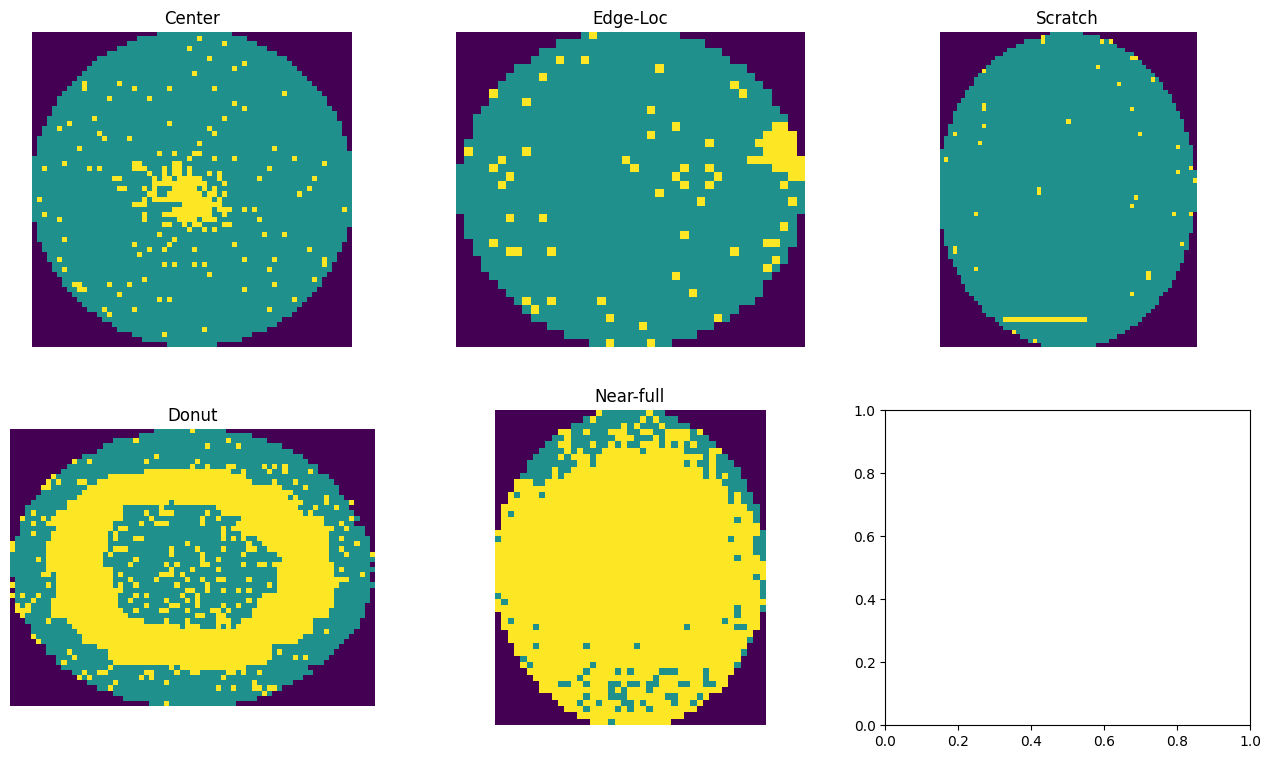

In [ ]:
# TODO: show a wafermap in each class using visualize_failure_types
# Below is an example call; you should show different wafer maps than example


In [ ]:
# TODO: output all images to failure type directory using output_all_wafer_maps


For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [ ]:
# TODO: Create dictionary called 'string2int' for converting string to numeric number


In [ ]:
def convert_failure_type(failure_type: str) -> int:
    return string2int[failure_type]

def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    return resize(wafer_map, output_shape, order=0, anti_aliasing=False, preserve_range=True)

In [ ]:
# TODO: Implement a function that creates dataframe columns to store the return values of the two tasks below using convert_failure_type and resize_wafer_map:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64)
#       (2) converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:

    return df

In [ ]:
# TODO: apply prepare_data


### STEP 2. Feature Engineering

You take a closer look at the columns in the **WM-811K** dataset and start thinking about which features could help identify **wafer map patterns**.  
To detect patterns, you’ll need **geometric information** — but none of the existing columns provide that kind of detail.  

That means you’ll have to **create your own features** directly from the `waferMap` column.  
You decide to engineer a total of **10 custom features** on your own.


In [ ]:
# TODO: Implement a function that detects connected failing dies using skimage and selects "one with the largest area(=salient region)" for each wafer map
# Hint: use connectivity=2

def get_salient_region(row: pd.Series) -> np.ndarray:

    return salient_region

In [ ]:
# TODO: Apply get_salient_region to the dataframe and save the results to a new column, and check if the dataframe has new column "salientRegion"


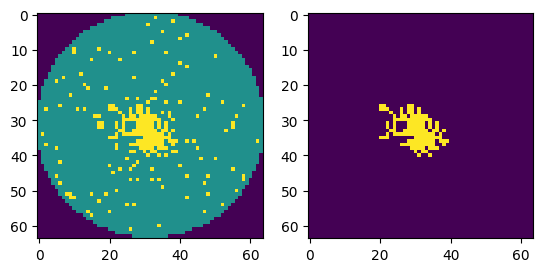

In [ ]:
# TODO: Verify the salient region
# Below is an example call; you should show different wafer maps than example

plt.show()

In [ ]:
# TODO: Implement a function that returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    
    return area_ratio

In [ ]:
# TODO: Implement a function that returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    
    return perimeter_ratio

In [ ]:
# TODO: Implement a function that returns the maximal distance between the salient region and the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    
    return max_distance

In [ ]:
# TODO: Implement a function that returns the minimal distance between the salient region and the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    
    return min_distance

In [ ]:
# TODO: Implement a function that returns the ratio of the length of the major axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    
    return major_axis_ratio

In [ ]:
# TODO: Implement a function that returns the ratio of the length of the minor axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    
    return minor_axis_ratio

In [ ]:
# TODO: Implement a function that returns the solidity, indicating the proportion of defective dies in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    
    return solidity

In [ ]:
# TODO: Implement a function that returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    
    return eccentricity

In [ ]:
# TODO: Implement a function that returns the ratio of the failed dies on the wafer map to the total number of dies on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    
    return yield_loss

In [ ]:
# TODO: Implement a function that returns the ratio of the failed dies on the outermost two rings of the wafer map to the total number of dies on the outermost two rings of the wafer map
# Use ring_label_from_outside helper function
def get_edge_yield_loss(row: pd.Series) -> float:

    return edge_yield_loss


# TODO: Implement a helper function that returns a numpy array highlighting the outermost two rings of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:

    return ring_labels

In [ ]:
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:

    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    return df

In [ ]:
# TODO: Apply create_feature_columns on the training dataframe

Area Ratio:           0.038
Max Dist from Center: 13.416
Min Dist from Center: 0.000
Perimeter Ratio:      2.458
Major Axis Ratio:     0.606
Minor Axis Ratio:     0.370
Solidity:             0.566
Eccentricity:         0.791
Yield Loss:           0.074
Edge Yield Loss:      0.040


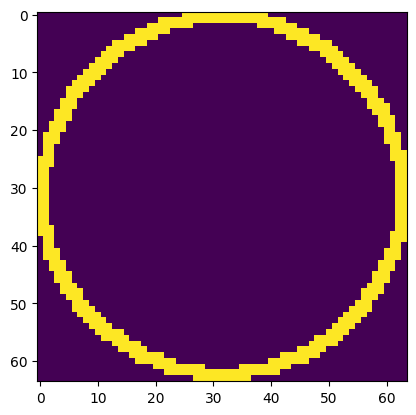

In [ ]:
# TODO: Verify feature functions
# Below is an example call; you should show different wafer maps than example

failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]

print("Area Ratio:          ", f'{get_area_ratio(row):.3f}')
print("Max Dist from Center:", f'{get_max_dist_from_center(row):.3f}')
print("Min Dist from Center:", f'{get_min_dist_from_center(row):.3f}')
print("Perimeter Ratio:     ", f'{get_perimeter_ratio(row):.3f}')
print("Major Axis Ratio:    ", f'{get_major_axis_ratio(row):.3f}')
print("Minor Axis Ratio:    ", f'{get_minor_axis_ratio(row):.3f}')
print("Solidity:            ", f'{get_solidity(row):.3f}')
print("Eccentricity:        ", f'{get_eccentricity(row):.3f}')
print("Yield Loss:          ", f'{get_yield_loss(row):.3f}')
print("Edge Yield Loss:     ", f'{get_edge_yield_loss(row):.3f}')

plt.imshow(ring_label_from_outside(row['waferMap']))

In [ ]:
# TODO: From the dataframe select the 10 features we want to use and extract them as X and extract the numerical failure type labels as y. 
# Then, split dataset into training and validation set. Use RANDOM_SEED for random_state


In [ ]:
# TODO: check train/validation distribution

plt.show()

### STEP 3. Model Training and Evaluation

You decide that a **Decision Tree** would be the easiest model to explain to others.  
However, relying on only one model wouldn’t be enough to judge its performance,  
so you also plan to build a **Support Vector Classifier (SVC)** for comparison.

Naturally, you’ll compare their **overall accuracy**,  
but you also decide to go a step further —  
by examining **accuracy per class** and the **confusion matrix** to see  
which **failure types** are most frequently misclassified.  
This insight will help you design a more accurate model later on.


In [ ]:
# TODO: initialize Decision Tree classifier with max tree depth of 3 and use RANDOM_SEED and train the Decision Tree classifier with the training data


In [ ]:
# TODO: Make a dictionary that is the reverse of the string2int mapping defined above.


In [ ]:
# TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):

    return accuracy

In [ ]:
# TODO: Implement a function that calculates the prediction accuracy for each failure type separately.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):

    return accuracies

In [ ]:
# TODO: get the predicted labels of the training data and calculate the accuracy, and calculate the accuracy for each failure type

print(f'Model accuracy on Decision Tree training data set is {acc_train:.2f}%')
print(f'Model accuracy on Decision Tree training data set for each class is {accuracies_train}')

In [ ]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

plt.show()

In [ ]:
# TODO: get the predicted labels of the validation data and calculate the accuracy, and calculate the accuracy for each failure type

print(f'Model accuracy on Decision Tree validation data set is {acc_valid:.2f}%')
print(f'Model accuracy on Decision Tree validation data set for each class is {accuracies_valid}%')

In [ ]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

plt.show()

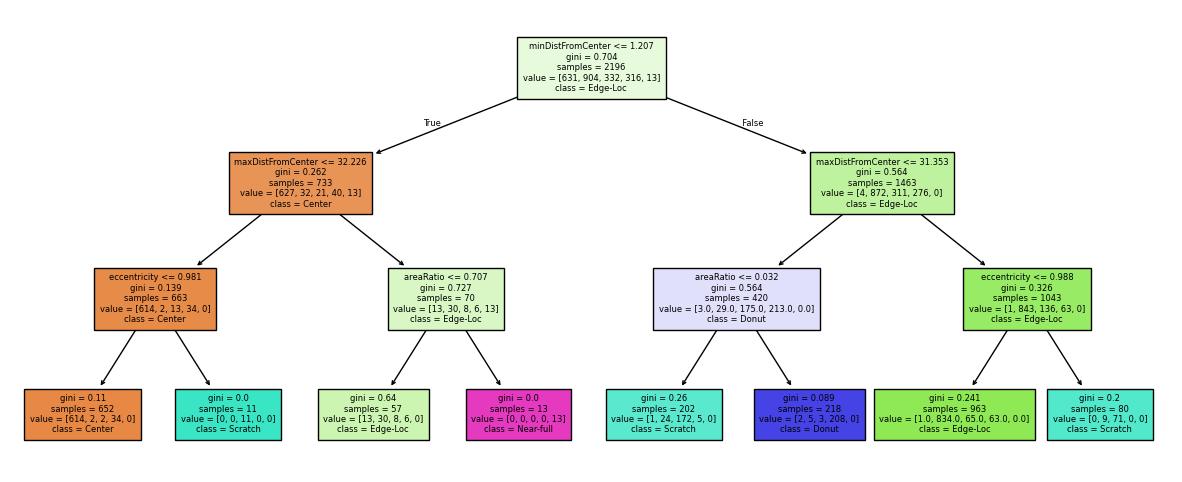

In [ ]:
# TODO: Plot decision tree
# Below is an example call; you should show different wafer maps than example 
# (make the plot size different if the resulting plot looks exactly the same as the example)

plt.show()

In [ ]:
# TODO: Initialize SVC, use RANDOM_SEED and kernel and train the SVC with the training data


In [ ]:
# TODO: get the predicted labels of the training data and calculate the accuracy, and calculate the accuracy for each failure type

print(f'Model accuracy on SVC training data set is {acc_train:.2f}%')
print(f'Model accuracy on SVC training data set for each class is {accuracies_train}')

In [ ]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

plt.show()

In [ ]:
# TODO: get the predicted labels of the validation data and calculate the accuracy, and calculate the accuracy for each failure type

print(f'Model accuracy on SVC validation data set is {acc_valid:.2f}%')
print(f'Model accuracy on SVC validation data set for each class is {accuracies_valid}%')

In [ ]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

plt.show()

In [ ]:
# TODO: Load test dataset as pandas dataframe


In [ ]:
# TODO: Apply data preparation function, feature extraction function, and create feature columns function on the test dataframe


In [ ]:
# TODO: From the dataframe select the 10 features we want to use and extract them as X


In [ ]:
# TODO: Get the predicted labels of the test data for both Decision Tree and SVC
# Hint: Don't forget to convert numeric labels back to string labels

In [ ]:
# Save output as `dt_scores.csv` and `svc_scores.csv`

pd.Series(pred_test_tree).to_csv('dt_scores.csv', header=False, index=False)
pd.Series(pred_test_svc).to_csv('svc_scores.csv', header=False, index=False)